In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np
import osmnx as ox
import json
import networkx as nx
import pickle
from data_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [6]:
### FUNCTION ###

def greater_than(data, greater_than_filter):
    data_filtered = list(filter(lambda x: x > greater_than_filter, data))
    return round((len(data_filtered)/len(data))*100, 2)

In [8]:
edges_buffer_scored_path = "output_data/analyse/edges_all_prop.gpkg"
edges_prop = gpd.read_file(edges_buffer_scored_path)
edges_prop.head()

,u,v,key,osmid,oneway,name,highway,maxspeed,reversed,length,...,prairies_prop,ombres_08_prop,ombres_13_prop,ombres_18_prop,arbustes_prop,arbres_prop,C_wavg_scaled,eaux_prop,canop,geometry
0,143403,21714981,0,120412669,False,Rue Professeur Morat,residential,30,False,12.119,...,0.0,0.00,0.0,0.00,0.0,0.60,0.588824,0.0,0.0,"POLYGON ((1846109.564 5172145.602, 1846110.144..."
1,143403,9226919131,0,521119804,True,Avenue Jean Mermoz,primary,50,False,26.832,...,0.0,0.00,0.0,0.00,0.0,0.91,0.588824,0.0,0.0,"POLYGON ((1846084.687 5172144.567, 1846084.135..."
2,143403,9226887756,0,120412669,False,Rue Professeur Morat,residential,30,True,11.073,...,0.0,0.76,0.0,0.00,0.0,0.30,0.588824,0.0,0.0,"POLYGON ((1846122.675 5172142.519, 1846122.463..."
3,143403,10810932922,0,521119804,True,Avenue Jean Mermoz,primary,50,False,15.606,...,0.0,0.36,0.0,0.00,0.0,0.72,0.588824,0.0,0.0,"POLYGON ((1846109.345 5172134.084, 1846108.797..."
4,21714981,9226922647,0,4087154,True,Rue Professeur Morat,unclassified,30,False,8.969,...,0.0,0.00,0.0,0.69,0.0,0.32,0.592353,0.0,0.0,"POLYGON ((1846096.611 5172125.102, 1846096.085..."


In [22]:
edges_prop.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'uniqId', 'prairies_prop', 'ombres_08_prop', 'ombres_13_prop',
       'ombres_18_prop', 'arbustes_prop', 'arbres_prop', 'C_wavg_scaled',
       'eaux_prop', 'canop', 'geometry'],
      dtype='object')

In [3]:
all_quantiles = pd.DataFrame()

In [4]:
# sns.set_style("darkgrid")
sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})

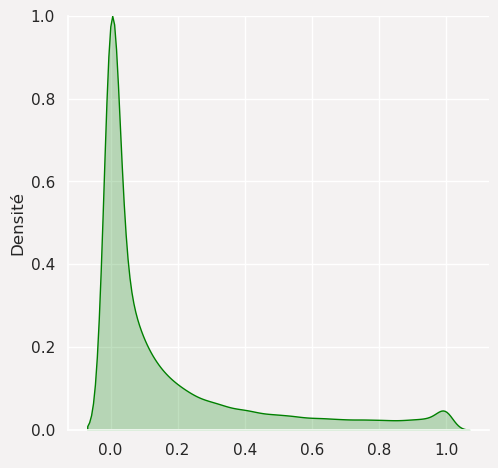

In [9]:
arbres = edges_prop["arbres_prop"]

all_quantiles["arbres"] = {"quantiles": np.quantile(arbres, q=[0.25,0.5,0.75]), "var": np.var(arbres), "mean": np.mean(arbres), "50%": greater_than(arbres, 0.5)}

arbres_ax = sns.displot(arbres, kind="kde", fill=True, color="green")

max_density = arbres_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
arbres_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)

plt.xlabel("") #Taux de recouvrement arbres
plt.ylabel("Densité")
plt.show()

In [10]:
print(all_quantiles)

                      arbres
quantiles  [0.0, 0.05, 0.22]
var                 0.065325
mean                0.167159
50%                    11.85


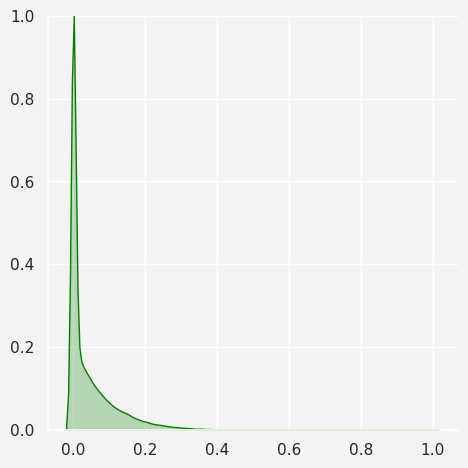

In [11]:
arbustes = edges_prop["arbustes_prop"]
all_quantiles["arbustes"] = {"quantiles": np.quantile(arbustes, q=[0.25,0.5,0.75]), "var": np.var(arbustes), "mean": np.mean(arbustes), "50%": greater_than(arbustes, 0.5)}
arbustes_ax = sns.displot(arbustes, kind="kde", fill=True, color="green")
# arbres_ax.fill_between(color="green")
# Obtenez la densité maximale
max_density = arbustes_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
arbustes_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
plt.xlabel("") #Taux de recouvrement arbustes
plt.ylabel("")
plt.show()

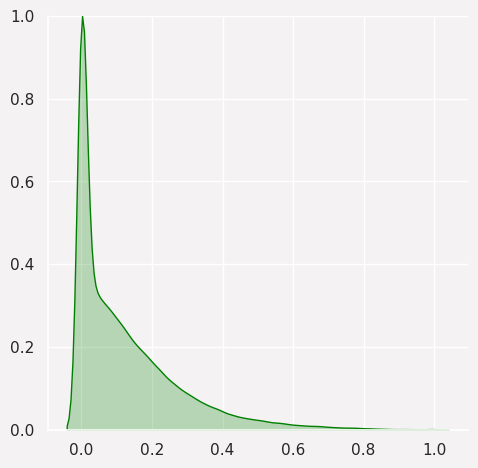

In [12]:
prairies = edges_prop["prairies_prop"]
all_quantiles["prairies"] = {"quantiles": np.quantile(prairies, q=[0.25,0.5,0.75]), "var": np.var(prairies), "mean": np.mean(prairies), "50%": greater_than(prairies, 0.5)}
prairies_ax = sns.displot(prairies, kind="kde", fill=True, color="green")

max_density = prairies_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
prairies_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
# arbres_ax.fill_between(color="green")
plt.xlabel("") #Taux de recouvrement prairies
plt.ylabel("")
plt.show()

In [13]:
ombres_08_path = "./output_data/network/edges/edges_buffered_ombres_08_prop_bounding.gpkg"
ombres_08_data = gpd.read_file(ombres_08_path)

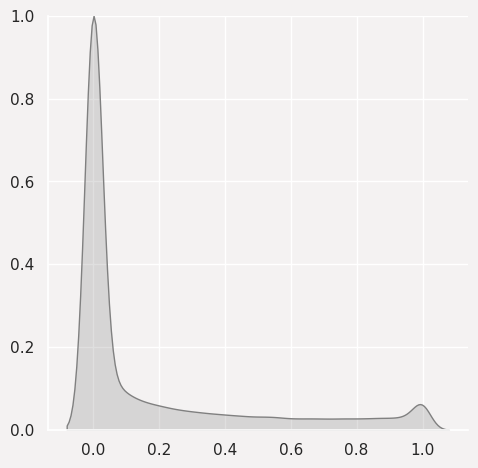

In [14]:
ombres_08 = ombres_08_data["ombres_08_prop"]
all_quantiles["ombres_08"] = {"quantiles": np.quantile(ombres_08, q=[0.25,0.5,0.75]), "var": np.var(ombres_08), "mean": np.mean(ombres_08), "50%": greater_than(ombres_08, 0.5)}
ombres_08_ax = sns.displot(ombres_08, kind="kde", fill=True, color="gray")
# arbres_ax.fill_between(color="green")
max_density = ombres_08_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
ombres_08_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
plt.xlabel("") #Taux de recouvrement ombres 8h
plt.ylabel("")
plt.show()

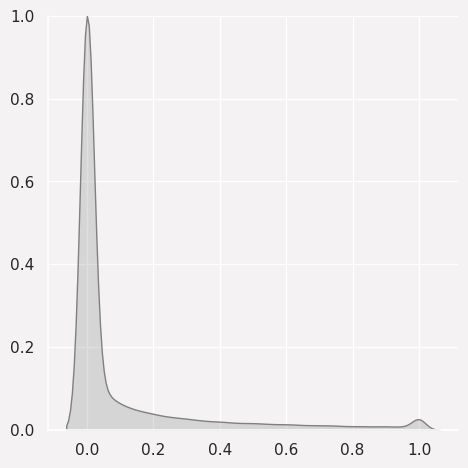

In [7]:
ombres_13 = edges_prop["ombres_13_prop"]
all_quantiles["ombres_13"] = {"quantiles": np.quantile(ombres_13, q=[0.25,0.5,0.75]), "var": np.var(ombres_13), "mean": np.mean(ombres_13), "50%": greater_than(ombres_13, 0.5)}
ombres_13_ax = sns.displot(ombres_13, kind="kde", fill=True, color="gray")
# arbres_ax.fill_between(color="green")
max_density = ombres_13_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
ombres_13_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
plt.xlabel("") #Taux de recouvrement ombres 13h
plt.ylabel("")
plt.show()

/home/yannis/anaconda3/envs/itineraire_fraicheur/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


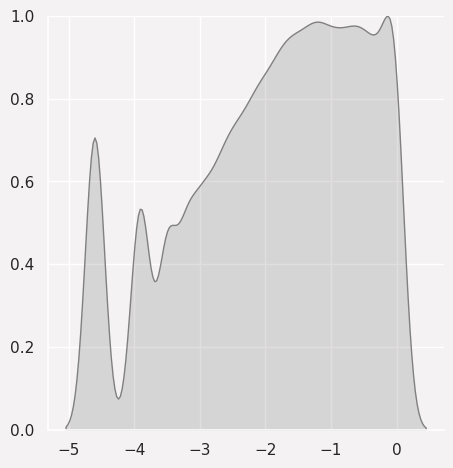

In [11]:
ombres_13 = edges_prop["ombres_13_prop"]
all_quantiles["ombres_13"] = {"quantiles": np.quantile(ombres_13, q=[0.25,0.5,0.75]), "var": np.var(ombres_13), "mean": np.mean(ombres_13), "50%": greater_than(ombres_13, 0.5)}
ombres_13_ax = sns.displot(np.log(ombres_13), kind="kde", fill=True, color="gray")
# arbres_ax.fill_between(color="green")
max_density = ombres_13_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
ombres_13_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
plt.xlabel("") #Taux de recouvrement ombres 13h
plt.ylabel("")
plt.show()

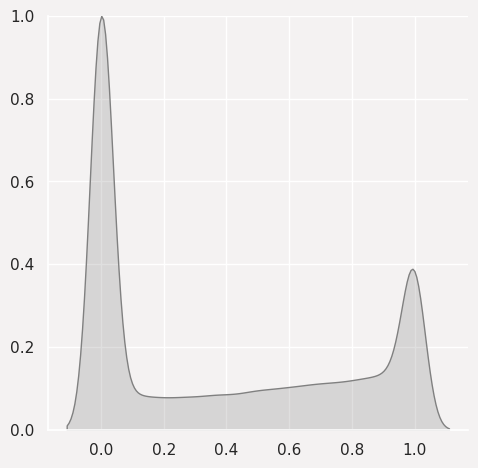

In [16]:
ombres_18 = edges_prop["ombres_18_prop"]
all_quantiles["ombres_18"] = {"quantiles": np.quantile(ombres_18, q=[0.25,0.5,0.75]), "var": np.var(ombres_18), "mean": np.mean(ombres_18), "50%": greater_than(ombres_18, 0.5)}
ombres_18_ax = sns.displot(ombres_18, kind="kde", fill=True, color="gray")

max_density = ombres_18_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
ombres_18_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
plt.xlabel("") #Taux de recouvrement ombres 18h
plt.ylabel("")
plt.show()

In [17]:
temp_path = "./output_data/network/edges/edges_buffered_temp_wavg_bounding_no_na.gpkg"
temp_data = gpd.read_file(temp_path)

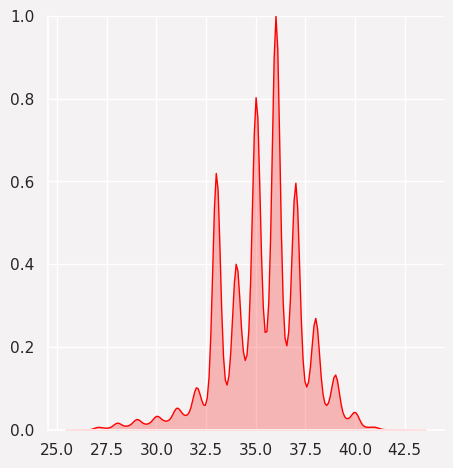

In [18]:
temp = temp_data["C_wavg"]
all_quantiles["temp"] = {"quantiles": np.quantile(temp, q=[0.25,0.5,0.75]), "var": np.var(temp), "mean": np.mean(temp), "50%": greater_than(temp, 0.5)}
temp_ax = sns.displot(temp, kind="kde", fill=True, color="red")
# arbres_ax.fill_between(color="green")
max_density = temp_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
temp_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
plt.xlabel("") #Température moyenne par segments
plt.ylabel("")
plt.show()

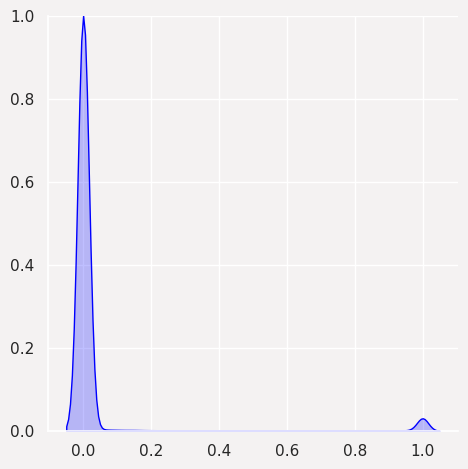

In [19]:
eaux = edges_prop["eaux_prop"]
all_quantiles["eaux"] = {"quantiles": np.quantile(eaux, q=[0.25,0.5,0.75]), "var": np.var(eaux), "mean": np.mean(eaux), "50%": greater_than(eaux, 0.5)}
eaux_ax = sns.displot(eaux, kind="kde", fill=True, color="blue")
max_density = eaux_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
eaux_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
plt.xlabel("") #Taux de recouvrement eaux
plt.ylabel("")
plt.show()

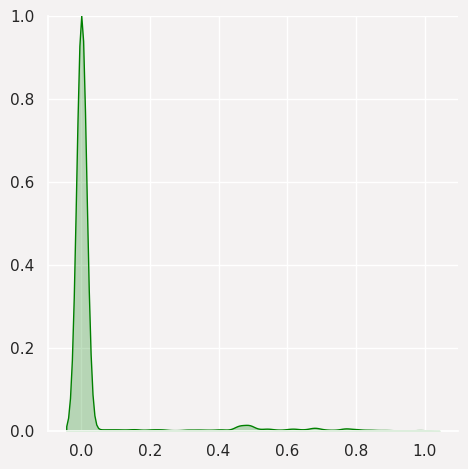

In [20]:
canop = edges_prop["canop"]
all_quantiles["canop"] = {"quantiles": np.quantile(canop, q=[0.25,0.5,0.75]), "var": np.var(canop), "mean": np.mean(canop), "50%": greater_than(canop, 0.5)}
canop_ax = sns.displot(canop, kind="kde", fill=True, color="green")
max_density = canop_ax.ax.collections[0].get_paths()[0].vertices[:, 1].max()

# Normalisez les valeurs de densité entre 0 et 1
canop_ax.ax.collections[0].get_paths()[0].vertices[:, 1] /= max_density
plt.ylim(0,1)
plt.xlabel("") #Indices de canopés parcs
plt.ylabel("")
plt.show()

In [21]:
print(all_quantiles)

                      arbres           arbustes           prairies  \
quantiles  [0.0, 0.05, 0.22]  [0.0, 0.01, 0.07]  [0.0, 0.08, 0.19]   
var                 0.065325           0.005095           0.023847   
mean                0.167159           0.044794           0.126899   
50%                    11.85               0.09               3.36   

                  ombres_08         ombres_13          ombres_18  \
quantiles  [0.0, 0.0, 0.24]  [0.0, 0.0, 0.09]  [0.0, 0.25, 0.81]   
var                0.086772          0.051733           0.162274   
mean               0.175938          0.109196           0.388789   
50%                   15.49              8.21              40.07   

                           temp             eaux            canop  
quantiles  [34.0, 35.44, 36.67]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  
var                    4.338108         0.034058          0.02622  
mean                   35.26334          0.04009         0.046451  
50%                       100.0     

In [36]:
# features = ['prairies_prop', 'ombres_08_prop', 'ombres_13_prop',
#        'ombres_18_prop', 'arbustes_prop', 'arbres_prop', 'C_wavg_scaled',
#        'eaux_prop', 'canop']

features = ['arbres_prop', 'ombres_08_prop', 'ombres_13_prop', "ombres_18_prop", "C_wavg_scaled", "arbustes_prop", "prairies_prop", "eaux_prop", "canop"]
all_prop = edges_prop[features]

In [37]:
corr_all_prop = all_prop.corr()

In [38]:
print(corr_all_prop)

                arbres_prop  ombres_08_prop  ombres_13_prop  ombres_18_prop  \
arbres_prop        1.000000       -0.021385       -0.064499       -0.006066   
ombres_08_prop    -0.021385        1.000000        0.647947        0.481858   
ombres_13_prop    -0.064499        0.647947        1.000000        0.500896   
ombres_18_prop    -0.006066        0.481858        0.500896        1.000000   
C_wavg_scaled     -0.310467        0.110966        0.106408        0.182819   
arbustes_prop      0.012801       -0.105108       -0.115657       -0.061836   
prairies_prop     -0.014634       -0.163594       -0.166367       -0.182145   
eaux_prop          0.115429       -0.048828       -0.044718       -0.081260   
canop              0.267624       -0.011743       -0.030157       -0.043696   

                C_wavg_scaled  arbustes_prop  prairies_prop  eaux_prop  \
arbres_prop         -0.310467       0.012801      -0.014634   0.115429   
ombres_08_prop       0.110966      -0.105108      -0.163594  

In [39]:
new_column_names = {
    'prairies_prop': 'Prairies',
    'ombres_08_prop': 'Ombres 8h',
    'ombres_13_prop': 'Ombres 13h',
    'ombres_18_prop': 'Ombres 18h',
    'arbustes_prop': 'Arbustes',
    'arbres_prop': 'Arbres',
    'C_wavg_scaled': 'Température',
    'eaux_prop': 'Eaux',
    'canop': 'Parcs'
}

# Use the rename() method to rename the columns
corr_all_prop = corr_all_prop.rename(columns=new_column_names)

In [40]:
old_row_names = corr_all_prop.index.tolist()

# Définir une liste avec les nouveaux noms de lignes que vous souhaitez utiliser
new_row_names = [
    'Arbres', 'Ombres 8h', 'Ombres 13h', 'Ombres 18h', 'Température', 'Arbustes', 'Prairies', 'Eaux', 'Parcs'
]

# Utilisez la méthode rename() avec l'argument index pour renommer les lignes
corr_all_prop = corr_all_prop.rename(index=dict(zip(old_row_names, new_row_names)))

<Axes: >

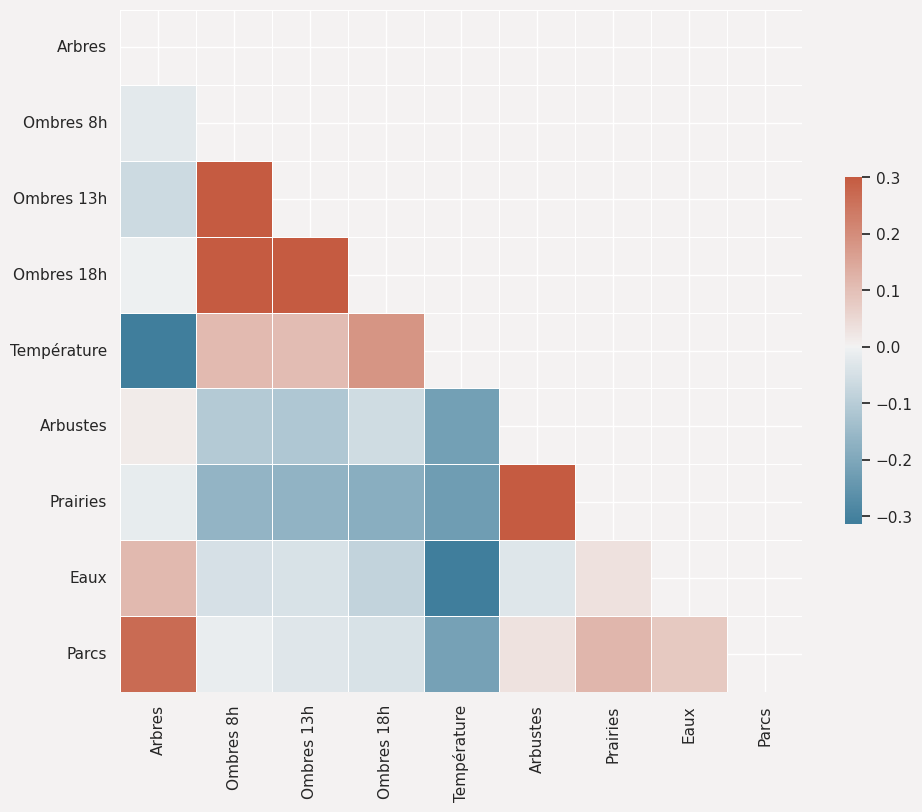

In [41]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_all_prop, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all_prop, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
parcs_canop = gpd.read_file("./input_data/parcs/parcs_canop.gpkg")

parcs_canop.columns

Index(['nom', 'indiccanop', 'gid', 'geometry'], dtype='object')

In [6]:
print(parcs_canop["indiccanop"].unique())

['0.57' '0.12' '0.11' '0.39' '0.00' '0.45' '0.48' '0.32' '0.49' '0.64'
 '0.15' '0.54' '0.16' '0.35' '0.84' '0.60' '0.91' '0.82' '0.38' '1.00'
 '0.34' '0.40' '0.43' '0.55' '0.25' '0.99' '0.83' '0.70' '0.26' '0.14'
 '0.41' '0.05' '0.46' '0.68' '0.67' '0.76' '0.86' '0.80' '0.85' '0.92'
 '0.10' '0.98' '0.47' '0.19' '0.37' '0.24' '0.23' '0.65' '0.44' '0.22'
 '0.72' '0.73' '0.04' '0.56' '0.90' '0.71' '0.87' '0.96' '0.88' '0.52'
 '0.95' '0.62' '0.89' '0.21' '0.63' '0.78' '0.29' '0.36' '0.66' '0.30'
 '0.31' '0.69' '0.09' '0.51' '0.58' '0.20' '0.74' '0.75' '0.53' '0.93'
 '0.97' '0.07' '0.28' '0.13' '0.94' '0.79' '0.08' '0.81' '0.18' '0.77'
 '0.02' '0.03' '0.06' '0.27' '0.42' '0.59' '0.61' '0.17' '0.50' '0.01'
 '0.33']


In [7]:
print(len(parcs_canop[parcs_canop["indiccanop"] == "0.00"]))

274


In [9]:
canop_intersec = gpd.overlay(edges_prop, parcs_canop)

In [10]:
canop_intersec.to_file("./output_data/analyse/intersection_canop_edges", layer="edges", driver="GPKG")

In [13]:
features = ['arbres_prop', 'ombres_08_prop', 'ombres_13_prop', "ombres_18_prop", "C_wavg_scaled", "arbustes_prop", "prairies_prop", "eaux_prop", "canop"]
canop_intersec_features = canop_intersec[features]
print(canop_intersec_features.corr())

                arbres_prop  ombres_08_prop  ombres_13_prop  ombres_18_prop  \
arbres_prop        1.000000       -0.043693       -0.088764       -0.008912   
ombres_08_prop    -0.043693        1.000000        0.556656        0.438504   
ombres_13_prop    -0.088764        0.556656        1.000000        0.493135   
ombres_18_prop    -0.008912        0.438504        0.493135        1.000000   
C_wavg_scaled     -0.188217        0.308082        0.286183        0.454016   
arbustes_prop     -0.064618       -0.143807       -0.135255       -0.155256   
prairies_prop     -0.240394       -0.273203       -0.245021       -0.307051   
eaux_prop         -0.006425       -0.084250       -0.114161       -0.182590   
canop              0.390012       -0.065937       -0.083353       -0.084456   

                C_wavg_scaled  arbustes_prop  prairies_prop  eaux_prop  \
arbres_prop         -0.188217      -0.064618      -0.240394  -0.006425   
ombres_08_prop       0.308082      -0.143807      -0.273203  